In [1]:
import numpy as np
import ghalton as gh
import pandas as pd
from scipy import stats
import scipy.linalg as la
import matplotlib
matplotlib.rcParams.update({'pdf.fonttype': 42, 'ps.fonttype': 42})
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Standard Kernel Code

In [3]:
%%file kernels.py
"""
Kernel Module.

Basic functions used for computing anisotropic Gaussian kernels.

Note: Matern and other kernels were removed from this version, since they were not used in the experiments in the end.
"""
import numpy as np
import scipy.linalg as la


def sqdist_gramix(x_p, x_q, length_scale):
    """
    Compute a gram matrix of euclidean distances between two datasets under an isotropic or anisotropic length scale.
    
    Parameters
    ----------
    x_p : np.ndarray [Size: (n_p, d)]
        A dataset
    x_q : np.ndarray [Size: (n_q, d)]
        A dataset
    length_scale : float or np.ndarray [Size: () or (1,) for isotropic; (d,) for anistropic]
        The length scale(s)
        
    Returns
    -------
    np.ndarray [Size: (n_p, n_q)]
        The resulting gram matrix
    """
    # Size: (n_p, d)
    z_p = np.atleast_2d(x_p) / length_scale
    # Size: (n_q, d)
    z_q = np.atleast_2d(x_q) / length_scale
    # Size: (n_p, n_q)
    d_pq = np.dot(z_p, z_q.transpose())
    # Size: (n_p,)
    d_p = np.sum(z_p ** 2, axis=1)
    # Size: (n_q,)
    d_q = np.sum(z_q ** 2, axis=1)
    # Size: (n_p, n_q)
    return d_p[:, np.newaxis] - 2 * d_pq + d_q


def gaussian_kernel_gramix(x_p, x_q, length_scale):
    """
    Compute a gram matrix of Gaussian kernel values between two datasets under an isotropic or anisotropic length scale.
    
    Parameters
    ----------
    x_p : np.ndarray [Size: (n_p, d)]
        A dataset
    x_q : np.ndarray [Size: (n_q, d)]
        A dataset
    length_scale : float or np.ndarray [Size: () or (1,) for isotropic; (d,) for anistropic]
        The length scale(s)
        
    Returns
    -------
    np.ndarray [Size: (n_p, n_q)]
        The resulting gram matrix
    """
    # Size: (n_p, n_q)
    return np.exp(-0.5 * sqdist_gramix(x_p, x_q, length_scale))


def convert_anisotropic(length_scale, d):
    """
    Convert isotropic length scale format to anisotropic length scale format.
    
    Parameters
    ----------
    length_scale : float or np.ndarray [Size: () or (1,) for isotropic; (d,) for anistropic]
        The length scale(s)
    d : int
        The dimensionality of the anisotropic kernel
    
    Returns
    -------
    np.ndarray [Size: (d,)]
        The anisotropic length scale(s)
    """
    # Size: (1,) or (d,)
    length_scale_array = np.atleast_1d(length_scale)
    # Make sure it is not more than 1 dimensional
    assert length_scale_array.ndim == 1
    # Make sure it is either isotropic or anisotropic
    assert length_scale_array.shape[0] in [1, d]
    # Convert it to anistropic only if it is isotropic or keep it the same
    if length_scale_array.shape[0] == 1:
        return np.repeat(length_scale_array, d)
    else:
        return length_scale_array

    
def gaussian_density_gramix(x, mu, sigma):
    """
    Compute a gram matrix of Gaussian density values of a dataset for multiple means.
    Parameters
    ----------
    x : np.ndarray [Size: (n, d)]
        A dataset
    mu : np.ndarray [Size: (m, d)]
        A dataset
    sigma : float or np.ndarray [Size: () or (1,) for isotropic; (d,) for anistropic]
        The standard deviations(s)
        
    Returns
    -------
    np.ndarray [Size: (n, m)]
        The resulting gram matrix
    """
    # Compute the scaling factor of a diagonal multivariate Gaussian distribution
    d = x.shape[-1]
    const = (np.sqrt(2 * np.pi) ** d) * np.prod(convert_anisotropic(sigma, d))
    # Size: (n, m)
    return gaussian_kernel_gramix(x, mu, sigma) / const


def gaussian_density_gramix_multiple(x, mu, sigma):
    """
    Compute the average gram matrix of Gaussian density values of a dataset for multiple arrays of means.
    
    Parameters
    ----------
    x : np.ndarray [Size: (n, d)]
        A dataset
    mu : np.ndarray [Size: (m, s, d)]
        A dataset where the average is to be taken over the middle dimension (s)
    sigma : float or np.ndarray [Size: () or (1,) for isotropic; (d,) for anistropic]
        The standard deviations(s)
        
    Returns
    -------
    np.ndarray [Size: (n, m)]
        The resulting gram matrix
    """    
    # Obtain and ensure the shape matches
    x = np.atleast_2d(x)
    n, d = x.shape
    m, s, d = mu.shape
    assert d == x.shape[-1]
    assert d == mu.shape[-1]
    # Size: (m * s, d)
    mu_2d = np.reshape(mu, (m * s, d))
    # Size: (n, m * s)
    gramix_2d = gaussian_density_gramix(x, mu_2d, sigma)
    # Size: (n, m, s)
    gramix_3d = np.reshape(gramix_2d, (n, m, s))
    # Size: (n, m)
    return np.mean(gramix_3d, axis=-1)


def negative_log_gaussian(x, mu, sigma):
    """
    Compute the negative log Gaussian density.
    
    Parameters
    ----------
    x : np.ndarray [Size: (d,)]
        The evaluation vector
    mu : np.ndarray [Size: (d,)]
        The mean vector
    sigma : np.ndarray [Size: (d, d)]
        The covariance matrix
        
    Returns
    -------
    float
        The negative log Gaussian density
    """
    lower = True
    # Size: (d, d)
    chol = la.cholesky(sigma, lower=lower)
    # Size: (d,)
    alpha = la.cho_solve((chol, lower), x - mu)
    # The negative log Gaussian density
    return 0.5 * np.dot(np.transpose(x - mu), alpha) + np.sum(np.log(chol.diagonal())) + 0.5 * sigma.shape[0] * np.log(2 * np.pi)

Overwriting kernels.py


In [4]:
from kernels import gaussian_kernel_gramix

# Standard Gaussian Process Regression

In [5]:
def gp_mean_weights(x, y, ls, sigma):
    """
    Compute weights of the kernels on each training point for the predictive mean of a Gaussian process regression model.
    
    This code uses Gaussian kernels only.
    
    Parameters
    ----------
    x : np.ndarray [Size: (n, d)]
        Training features
    y : np.ndarray [Size: (n,)]
        Training targets
    ls : float or np.ndarray [Size: () or (1,) for isotropic; (d,) for anistropic]
        The length scale(s)
    sigma : float
        Noise standard deviation
    
    Returns
    -------
    np.ndarray [Size: (n,)]
        The weights of the kernels on each training point
    """
    # Size: (n, n)
    k = gaussian_kernel_gramix(x, x, ls)
    # Size: (n, n)
    lower = True
    k_chol = la.cholesky(k + sigma**2 * np.eye(x.shape[0]), lower=lower)
    # Size: (n,)
    return la.cho_solve((k_chol, lower), y)


def gp_pred(x_q, x, y, ls, sigma):
    """
    Compute the predictive mean and covariance of a Gaussian process regression model.
    
    This code uses Gaussian kernels only.
    
    Parameters
    ----------
    x_q : np.ndarray [Size: (n_q, d)]
        Query features
    x : np.ndarray [Size: (n, d)]
        Training features
    y : np.ndarray [Size: (n,)]
        Training targets
    ls : float or np.ndarray [Size: () or (1,) for isotropic; (d,) for anistropic]
        The length scale(s)
    sigma : float
        Noise standard deviation
    
    Returns
    -------
    np.ndarray [Size: (n_q,)]
        The predictive mean on the query points
    np.ndarray [Size: (n_q, n_q)]
        The predictive covariance between the query points
    """
    # Size: (n, n)
    k = gaussian_kernel_gramix(x, x, ls)
    # Size: (n, n_q)
    k_q = gaussian_kernel_gramix(x, x_q, ls)
    # Size: (n_q, n_q)
    k_qq = gaussian_kernel_gramix(x_q, x_q, ls)
    # Size: (n, n)
    lower = True
    k_chol = la.cholesky(k + sigma**2 * np.eye(x.shape[0]), lower=lower)
    # Size: (n, n_q)
    h = la.cho_solve((k_chol, lower), k_q)
    # Size: (n_q,)
    f_mean = np.dot(y, h)
    # Size: (n_q, n_q)
    f_cov = k_qq - np.dot(np.transpose(k_q), h)
    return f_mean, f_cov

# True Latent Function $f$

We will specify the true latent function $f$ using a Gaussian process mean.

In [6]:
# Specify training data to specify the Gaussian process (example taken from Rasmussen and Williams 2006)
x = np.array([-4, -3, -1, 0, 2])[:, np.newaxis]
y = np.array([-2, 0, 1, 2, -1])

# Specify query points for visualization
x_q = np.linspace(-6, 6, 250)[:, np.newaxis]

In [7]:
# Specify hyperparameters
ls = 1.
sigma = 0.

# Compute the predictive distribution of the Gaussian process regression on the query points
f_mean, f_cov = gp_pred(x_q, x, y, ls, sigma)
f_var = f_cov.diagonal()
f_std = np.sqrt(f_var)

# Find the bounds to visualize uncertainty
f_top = f_mean + 2 * f_std
f_bot = f_mean - 2 * f_std

# This is Gaussian process for the true function
f_mean_true = f_mean
f_bot_true = f_bot
f_top_true = f_top

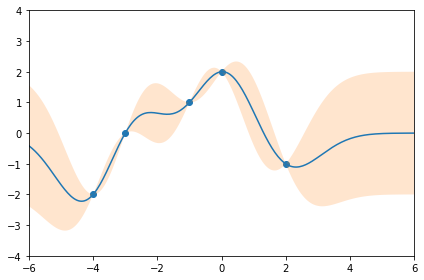

In [8]:
# Plot the Gaussian process we just generated
# Our true function is just the mean of this Gaussian process
def plot():
    plt.scatter(x, y)
    plt.plot(x_q, f_mean)
    plt.fill_between(x_q.ravel(), f_bot, f_top, alpha=0.2)
    plt.xlim((-6, 6))
    plt.ylim((-4, 4))
    plt.tight_layout()
plot()

In [9]:
# Let the true latent function f be the mean of the above Gaussian process

# Cache the information required to compute f
alpha_fix = gp_mean_weights(x, y, ls, sigma).copy()
x_fix = x.copy()
ls_f_fix = 1.

# Define f
def f(x_q):
    return np.dot(alpha_fix, gaussian_kernel_gramix(x_fix, x_q, ls_f_fix))

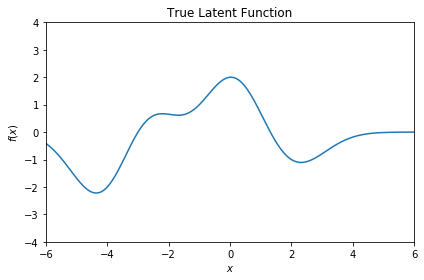

In [10]:
# Plot the true latent function
def plot():
    x_q = np.linspace(-6, 6, 250)[:, np.newaxis]
    plt.plot(x_q, f(x_q))
    plt.xlim((-6, 6))
    plt.ylim((-4, 4))
    plt.xlabel(r'$x$')
    plt.ylabel(r'$f(x)$')
    plt.title('True Latent Function')
    plt.tight_layout()
plot()

# Simulation Process $p_{X|Y}$

We will use a Gaussian distribution for the simulation process,

$$p_{X|Y}(x | y) = \mathcal{N}(x ; r(y), 0.25^{2}).$$

The mean of the simulation process $r$ will also be specified by a Gaussian process mean.

To generate data from the simulation process, we sample $Y$ from any proposal marginal distribution,

$$y_{i} \sim U(-6, 6), \quad i = 1, \dots, n.$$

Then, we sample from the simulation process,

$$x_{i} \sim p_{X|Y}(\cdot | y_{i}), \quad i = 1, \dots, n.$$

In [11]:
# In a similar spirit, specify the training data and hyperparameters needed for the likelihood mean r
y_sim = np.array([-5, -3, -1, 1, 4])[:, np.newaxis]
x_sim = 2 * (np.array([-2, -1, -3, 2, 3]))
ls_sim = 1.
sigma_sim = 0.

# Cache the information required to compute r
beta_fix = gp_mean_weights(y_sim, x_sim, ls_sim, sigma_sim).copy()

# Define r
def r(y):
    return np.dot(beta_fix, gaussian_kernel_gramix(y_sim, y, ls_sim))[:, np.newaxis]

In [12]:
# Define the noise level in p(x|y)
r_noise_std = 0.25

# Generate the data for the simulation process
np.random.seed(100)
n = 100
y = np.random.uniform(-6, 6, (n, 1))
x = r(y) + r_noise_std * np.random.randn(n, 1)

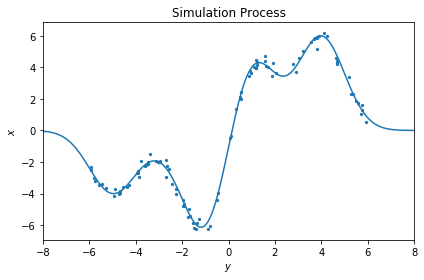

In [13]:
# Plot the simulation process
def plot():
    y_q = np.linspace(-8, 8, 250)[:, np.newaxis]
    plt.plot(y_q, r(y_q))
    plt.scatter(y, x, s=5)
    plt.xlim((-8, 8))
    plt.tight_layout()
    plt.xlabel(r'$y$')
    plt.ylabel(r'$x$')
    plt.title('Simulation Process')
    plt.tight_layout()
plot()

# Observation Process $p_{Z|Y}$

The observation process is governed by the latent function and the simulation process.

First, if $x$ was available, then the observations $z$ would be noisy observations of the latent function,

$$p(z | x) = \mathcal{N}(z; f(x), 0.25^{2}).$$

However, during the observation process, we can only control $y$.

To generate data from the observation process, we sample $Y$ from any proposal marginal distribution,

$$\tilde{y}_{j} \sim U(-6, 6), \quad j = 1, \dots, m.$$

Then, we sample from the simulation process and then pass it through the observation process.

$$\tilde{x}_{j} \sim p_{X|Y}(\cdot | \tilde{y}_{j}), \quad j = 1, \dots, m,$$
$$\tilde{z}_{j} \sim p_{Z|X}(\cdot | \tilde{x}_{j}), \quad j = 1, \dots, m.$$

Note that $\{\tilde{x}_{j}\}_{j = 1}^{m}$ cannot be observed during this process, so it is discarded and we end up with $\{\tilde{y}_{j}, \tilde{z}_{j}\}_{j = 1}^{m}$.

Equivalently, to generate the data, we choose non-trivial functions $r$ and $f$ and generate $X_{i} = r(Y_{i}) + \eta_{i}$ and $\tilde{Z}_{j} = f(r(\tilde{Y}_{j}) + \tilde{\eta}_{j}) + \tilde{\xi}_{j}$, where $Y_{i}, \tilde{Y}_{j} \sim U(-6, 6)$ and $ \eta_{i}, \tilde{\eta}_{j}, \tilde{\xi}_{j} \sim \mathcal{N}(0, 0.25^{2})$ for all $i \in \{1, \dots, n\}$ and $j \in \{1, \dots, m\}$.

Given $y$, the target is observed with mean $\mathbb{E}[Z | Y = y] = \mathbb{E}[f(r(y) + \tilde{\eta}) + \tilde{\xi}] = \mathbb{E}[f(r(y) + \tilde{\eta})] = \mathbb{E}[f(X) | Y = y] =: g(y).$

In [14]:
# Define the noise level in p(z|x)
f_noise_std = 0.25

# Generate the data for the observation process
np.random.seed(0)
m = 150
y_tilde = np.random.uniform(-6, 6, (m, 1))
x_tilde = r(y_tilde)  + r_noise_std * np.random.randn(m, 1)
z_tilde = f(x_tilde) + f_noise_std * np.random.randn(m)

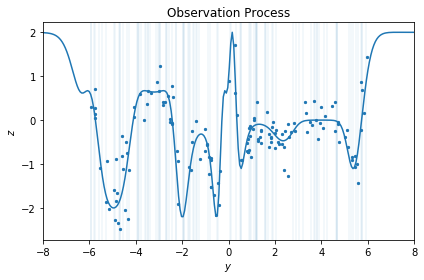

In [15]:
# Plot the observation process, and also show the y positions of the simulation process
def plot():
    y_q = np.linspace(-8, 8, 250)[:, np.newaxis]
    [plt.axvline(y_, linewidth=0.1) for y_ in y]
    plt.plot(y_q, f(r(y_q)))
    plt.scatter(y_tilde, z_tilde, s=5)
    plt.xlim((-8, 8))
    plt.tight_layout()
    plt.xlabel(r'$y$')
    plt.ylabel(r'$z$')
    plt.title('Observation Process')
    plt.tight_layout()
plot()

# Deconditional Mean Embeddings and Task Transformed Gaussian Processes

In [16]:
%%file ttgp.py
"""
Task Transformed Gaussian Process Module.

Core functions for task transformed Gaussian processes.
"""
import numpy as np
import scipy.linalg as la
from kernels import gaussian_kernel_gramix, negative_log_gaussian


def transformation_matrix(y, y_tilde, ls_y, lamb):
    """
    Compute the transformation matrix for DME/TTGP, defined as $A := (L + n \lambda I)^{-1} \tilde{L}$.
    
    This code uses Gaussian kernels only.
    
    Parameters
    ----------
    y : np.ndarray [Size: (n, d_y)]
        Samples of the mediating variable from the simulation process
    y_tilde : np.ndarray [Size: (m, d_y)]
        Samples of the mediating variable from the observation process
    ls_y : float or np.ndarray [Size: () or (1,) for isotropic; (d_y,) for anistropic]
        The length scale(s) of the mediating variable(s)
    lamb : float
        Regularization parameter
    
    Returns
    -------
    np.ndarray [Size: (n, m)]
        The transformation matrix
    """
    # Size: (n, n)
    l = gaussian_kernel_gramix(y, y, ls_y)
    # Size: (n, m)
    tilde_l = gaussian_kernel_gramix(y, y_tilde, ls_y)
    # Size: (n, n)
    n = y.shape[0]
    lower = True
    l_chol = la.cholesky(l + n * lamb * np.eye(n), lower=lower)
    # Size: (n, m)
    a = la.cho_solve((l_chol, lower), tilde_l)
    return a


def tgp_pred(x_q, x, z_tilde, ls_x, trans_mat, noise_cov):
    """
    Compute the posterior predictive mean and covariance of a transformed Gaussian process with a given transformation and noise covariance.
    
    This code uses Gaussian kernels only.
    
    Parameters
    ----------
    x_q : np.ndarray [Size: (n_q, d)]
        The query features
    x : np.ndarray [Size: (n, d)]
        The features
    z_tilde : np.ndarray [Size: (m,)]
        The transformed targets
    ls_x: float or np.ndarray [Size: () or (1,) for isotropic; (d_y,) for anistropic]
        The length scale(s) of the input variable(s)
    trans_mat : np.ndarray [Size: (n, m)]
        The transformation matrix
    noise_cov: np.ndarray [Size: (m, m)]
        The noise covariance
        
    Returns
    -------
    np.ndarray [Size: (n_q,)]
        The predictive mean on the query points
    np.ndarray [Size: (n_q, n_q)]
        The predictive covariance between the query points
    """
    # Size: (n, n)
    k = gaussian_kernel_gramix(x, x, ls_x)
    # Size: (m, m)
    s = np.dot(np.transpose(trans_mat), np.dot(k, trans_mat)) + noise_cov
    # Size: (m, m)
    lower = True
    s_chol = la.cholesky(s, lower=lower)
    # Size: (m, n)
    smt = la.cho_solve((s_chol, lower), np.transpose(trans_mat))
    # Size: (n, n_q)
    k_q = gaussian_kernel_gramix(x, x_q, ls_x)
    # Size: (n_q, n_q)
    k_qq = gaussian_kernel_gramix(x_q, x_q, ls_x)
    # Size: (m, n_q)
    smt_k_q = np.dot(smt, k_q)
    # Size: (n_q,)
    f_mean = np.dot(np.transpose(smt_k_q), z_tilde)
    # Size: (n_q, n_q)
    f_cov = k_qq - np.dot(np.transpose(smt_k_q), np.dot(np.transpose(trans_mat), k_q))
    # The posterior predictive mean and covariance of the latent function
    return f_mean, f_cov
           

def ttgp_pred(x_q, x, y, y_tilde, z_tilde, ls_x, ls_y, sigma, full=True):
    """
    Compute the posterior predictive mean and covariance of a task transformed Gaussian process.
    
    This code uses Gaussian kernels only.
    
    Parameters
    ----------
    x_q : np.ndarray [Size: (n_q, d_x)]
        The query features
    x : np.ndarray [Size: (n, d_x)]
        The features from the transformation set
    y : np.ndarray [Size: (n, d_y)]
        The mediators from the transformation set
    y_tilde: np.ndarray [Size: (m, d_y)]
        The mediators from the task set
    z_tilde : np.ndarray [Size: (m,)]
        The targets from the task set
    ls_x: float or np.ndarray [Size: () or (1,) for isotropic; (d_y,) for anistropic]
        The length scale(s) of the input variable(s)
    ls_y: float or np.ndarray [Size: () or (1,) for isotropic; (d_y,) for anistropic]
        The length scale(s) of the mediating variable(s)
    sigma : float
        The noise standard deviation
    full : boolean, optional
        Whether to do full Bayesian inference on g or use maximum a posteriori approximations on g
        
    Returns
    -------
    np.ndarray [Size: (n_q,)]
        The predictive mean on the query points
    np.ndarray [Size: (n_q, n_q)]
        The predictive covariance between the query points
    """
    # Size of the transformation and task datasets
    n = y.shape[0]
    m = y_tilde.shape[0]
    # The equivalent regularization parameter from noise standard deviation due to DME-TTGP equivalence
    lamb = sigma ** 2 / n
    # Size: (n, m)
    trans_mat = transformation_matrix(y, y_tilde, ls_y, lamb)
    # Compute the noise covariance depending on whether we are performing full Bayesian inference on g
    if full:
        # Size: (m, m)
        l_tt = gaussian_kernel_gramix(y_tilde, y_tilde, ls_y)
        # Size: (n, m)
        l_t = gaussian_kernel_gramix(y, y_tilde, ls_y)
        # Size: (m, m)
        noise_cov = l_tt + sigma ** 2 * np.eye(m) - np.dot(np.transpose(l_t), trans_mat)
    else:
        # Size: (m, m)
        noise_cov = sigma ** 2 * np.eye(m)
    # Once we have the transformation and noise covariance, apply the transformed Gaussian process equations for prediction
    return tgp_pred(x_q, x, z_tilde, ls_x, trans_mat, noise_cov)


def tgp_nlml(x, z_tilde, ls_x, trans_mat, noise_cov):
    """
    Compute the negative log marginal likelihood of a transformed Gaussian process.
    
    This code uses Gaussian kernels only.
    
    Parameters
    ----------
    x : np.ndarray [Size: (n, d)]
        The features
    z_tilde : np.ndarray [Size: (m,)]
        The transformed targets
    ls_x: float or np.ndarray [Size: () or (1,) for isotropic; (d_y,) for anistropic]
        The length scale(s) of the input variable(s)
    trans_mat : np.ndarray [Size: (n, m)]
        The transformation matrix
    noise_cov: np.ndarray [Size: (m, m)]
        The noise covariance
        
    Returns
    -------
    float
        The negative log marginal likelihood
    """
    k = gaussian_kernel_gramix(x, x, ls_x)
    s = np.dot(np.transpose(trans_mat), np.dot(k, trans_mat)) + noise_cov
    return negative_log_gaussian(z_tilde, 0, s)


def ttgp_nlml(x, y, y_tilde, z_tilde, ls_x, ls_y, sigma, full=True):
    """
    Compute the negative log marginal likelihood of a task transformed Gaussian process.
    
    This code uses Gaussian kernels only.
    
    Parameters
    ----------
    x : np.ndarray [Size: (n, d_x)]
        The features from the transformation set
    y : np.ndarray [Size: (n, d_y)]
        The mediators from the transformation set
    y_tilde: np.ndarray [Size: (m, d_y)]
        The mediators from the task set
    z_tilde : np.ndarray [Size: (m,)]
        The targets from the task set
    ls_x: float or np.ndarray [Size: () or (1,) for isotropic; (d_y,) for anistropic]
        The length scale(s) of the input variable(s)
    ls_y: float or np.ndarray [Size: () or (1,) for isotropic; (d_y,) for anistropic]
        The length scale(s) of the mediating variable(s)
    sigma : float
        The noise standard deviation
    full : boolean, optional
        Whether to do full Bayesian inference on g or use maximum a posteriori approximations on g
        
    Returns
    -------
    float
        The negative log marginal likelihood
    """    
    # Size of the transformation and task datasets
    n = y.shape[0]
    m = y_tilde.shape[0]
    # The equivalent regularization parameter from noise standard deviation due to DME-TTGP equivalence
    lamb = sigma ** 2 / n
    # Size: (n, m)
    trans_mat = transformation_matrix(y, y_tilde, ls_y, lamb)
    # Compute the noise covariance depending on whether we are performing full Bayesian inference on g
    if full:
        # Size: (m, m)
        l_tt = gaussian_kernel_gramix(y_tilde, y_tilde, ls_y)
        # Size: (n, m)
        l_t = gaussian_kernel_gramix(y, y_tilde, ls_y)
        # Size: (m, m)
        noise_cov = l_tt + sigma ** 2 * np.eye(m) - np.dot(np.transpose(l_t), trans_mat)
    else:
        # Size: (m, m)
        noise_cov = sigma ** 2 * np.eye(m)
    # Once we have the transformation and noise covariance, apply the transformed Gaussian process equations for learning
    return tgp_nlml(x, z_tilde, ls_x, trans_mat, noise_cov)

Overwriting ttgp.py


In [17]:
from ttgp import ttgp_pred, ttgp_nlml

# Task Transformed Gaussian Processes with Initial Hyperparameters

In [18]:
# Specify initial hyperparameters
ls_x_init = 1.
ls_y_init = 1.
sigma_init = 0.1

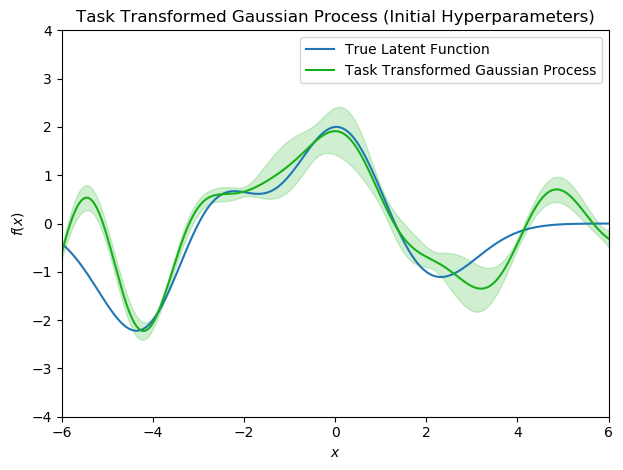

In [19]:
def plot():
    
    # Compute the posterior predictive mean and covariance of the task transformed Gaussian process
    x_q = np.linspace(-6, 6, 250)[:, np.newaxis]
    f_mean, f_cov = ttgp_pred(x_q, x, y, y_tilde, z_tilde, ls_x_init, ls_y_init, sigma_init, full=True)
    f_var = f_cov.diagonal()
    f_std = np.sqrt(f_var)
    f_top = f_mean + 2 * f_std
    f_bot = f_mean - 2 * f_std

    # Plot the true latent function and the recovered latent function from the task transformed Gaussian process
    sns.set()
    sns.reset_orig()
    x_q = np.linspace(-6, 6, 250)[:, np.newaxis]
    plt.plot(x_q, f(x_q), label='True Latent Function')
    plt.plot(x_q, f_mean, c=sns.xkcd_rgb['green'], label='Task Transformed Gaussian Process')
    plt.fill_between(x_q.ravel(), f_bot, f_top, color=sns.xkcd_rgb['green'], alpha=0.2)
    plt.xlabel(r'$x$')
    plt.ylabel(r'$f(x)$')
    plt.title('Task Transformed Gaussian Process (Initial Hyperparameters)')
    plt.xlim((-6, 6))
    plt.ylim((-4, 4))
    plt.legend()
    plt.tight_layout()
plot()

# Task Transformed Gaussian Processes with Learned Hyperparameters

In [20]:
# Setup the hyperparameter learning objective (hyperparameters are optimized in log space)
def objective(log_hypers):
    [ls_x, ls_y, sigma] = np.exp(log_hypers)
    return ttgp_nlml(x, y, y_tilde, z_tilde, ls_x, ls_y, sigma, full=True)

# Optimize the hyperparameters under the marginal likelihood objective (no auto-differentiation used, just finite difference)
from scipy.optimize import minimize
hypers_init = [ls_x_init, ls_y_init, sigma_init]
solution = minimize(objective, np.log(hypers_init))
log_hypers_opt = solution.x
hypers_opt = np.exp(log_hypers_opt)
[ls_x_opt, ls_y_opt, sigma_opt] = hypers_opt

# Print the results
print('Initial Hyperparameters: {0} \n\t Negative Log Marginal Likelihood: {1}'.format(hypers_init, objective(np.log(hypers_init))))
print('Learned Hyperparameters: {0} \n\t Negative Log Marginal Likelihood: {1}'.format(hypers_opt, objective(np.log(hypers_opt))))

Initial Hyperparameters: [1.0, 1.0, 0.1] 
	 Negative Log Marginal Likelihood: 1548.082150308096
Learned Hyperparameters: [1.03741465 0.35222978 0.40144024] 
	 Negative Log Marginal Likelihood: 105.72771406339325


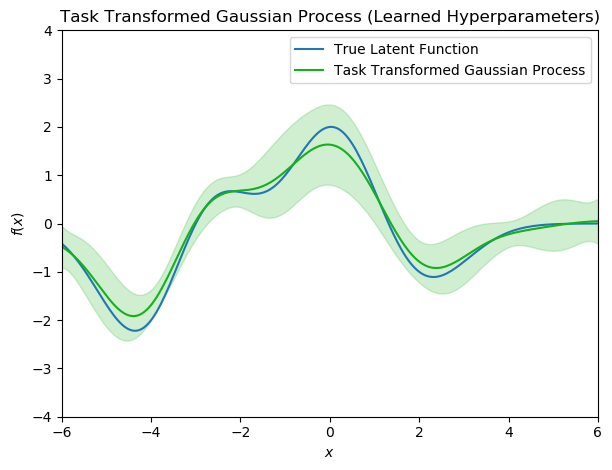

In [21]:
def plot():
    
    # Compute the posterior predictive mean and covariance of the task transformed Gaussian process
    x_q = np.linspace(-6, 6, 250)[:, np.newaxis]
    f_mean, f_cov = ttgp_pred(x_q, x, y, y_tilde, z_tilde, ls_x_opt, ls_y_opt, sigma_opt, full=True)
    f_var = f_cov.diagonal()
    f_std = np.sqrt(f_var)
    f_top = f_mean + 2 * f_std
    f_bot = f_mean - 2 * f_std

    # Plot the true latent function and the recovered latent function from the task transformed Gaussian process
    sns.set()
    sns.reset_orig()
    x_q = np.linspace(-6, 6, 250)[:, np.newaxis]
    plt.plot(x_q, f(x_q), label='True Latent Function')
    plt.plot(x_q, f_mean, c=sns.xkcd_rgb['green'], label='Task Transformed Gaussian Process')
    plt.fill_between(x_q.ravel(), f_bot, f_top, color=sns.xkcd_rgb['green'], alpha=0.2)
    plt.xlabel(r'$x$')
    plt.ylabel(r'$f(x)$')
    plt.title('Task Transformed Gaussian Process (Learned Hyperparameters)')
    plt.xlim((-6, 6))
    plt.ylim((-4, 4))
    plt.legend()
    plt.tight_layout()
plot()

# Overall Visualization
## Simulation Process, Observation Process, Latent Function Recovery Comparison

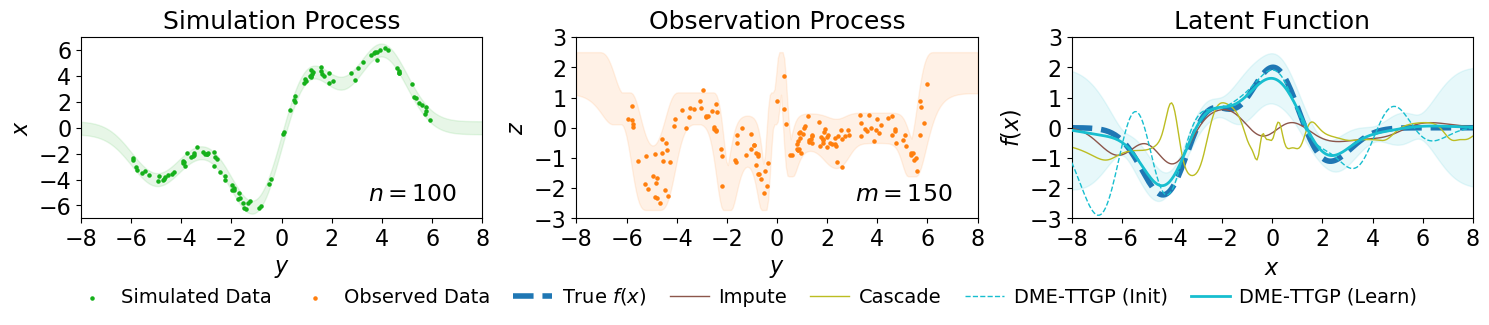

In [22]:
def plot():
    
    # Plot Setup
    sns.set()
    sns.reset_orig()
    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches((15, 3))

    # Visualize Simulation Process
    y_q = np.linspace(-8, 8, 250)[:, np.newaxis]
    ax[0].scatter(y, x, c=sns.xkcd_rgb['green'], s=20, marker='.', label='Simulated Data')
    ax[0].fill_between(y_q.ravel(), r(y_q).ravel() + 2 * r_noise_std, r(y_q).ravel() - 2 * r_noise_std, color=sns.xkcd_rgb['green'], alpha=0.1)
    ax[0].set_xlim((-8, 8))
    ax[0].set_ylim((-7, 7))
    ax[0].set_xlabel('$y$', fontsize=16)
    ax[0].set_ylabel('$x$', fontsize=16)
    ax[0].set_yticks([-6, -4, -2, 0, 2, 4, 6])
    ax[0].set_title('Simulation Process', fontsize=18)
    ax[0].text(7, -7 * 0.8, r'$n=%d$' % n, horizontalalignment='right', fontsize=17)
    for tick in ax[0].xaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    for tick in ax[0].yaxis.get_major_ticks():
        tick.label.set_fontsize(16)
    plt.tight_layout()
    
    # Visualize Observation Process
    y_q = np.linspace(-8, 8, 250)[:, np.newaxis]
    z_q_low = np.zeros(y_q.shape[0])
    z_q_high = np.zeros(y_q.shape[0])
    for i, yy in enumerate(y_q.ravel()):
        xx = r(yy)[0, 0]
        xx_low = xx - 2 * r_noise_std
        xx_high = xx + 2 * r_noise_std
        xx_range = np.linspace(xx_low, xx_high, 100)
        zz_range = f(xx_range[:, np.newaxis])
        zz_low = np.min(zz_range) - 2 * f_noise_std
        zz_high = np.max(zz_range) + 2 * f_noise_std
        z_q_low[i] = zz_low
        z_q_high[i] = zz_high
    ax[1].scatter(y_tilde, z_tilde, c=sns.color_palette()[1], s=20, marker='.', label='Observed Data')
    ax[1].fill_between(y_q.ravel(), z_q_high, z_q_low, color=sns.color_palette()[1], alpha=0.1)
    ax[1].set_xlim((-8, 8))
    ax[1].set_ylim((-3, 3))
    ax[1].set_xlabel('$y$', fontsize=16)
    ax[1].set_ylabel('$z$', fontsize=16)
    ax[1].set_title('Observation Process', fontsize=18)
    ax[1].text(7, -3 * 0.8, r'$m=%d$' % m, horizontalalignment='right', fontsize=17)
    for tick in ax[1].xaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    for tick in ax[1].yaxis.get_major_ticks():
        tick.label.set_fontsize(16)
    plt.tight_layout()
    
    # Computation: Task Transformed Gaussian Process (Initial Hyperparameters)
    x_q = np.linspace(-8, 8, 250)[:, np.newaxis]
    f_mean, f_cov = ttgp_pred(x_q, x, y, y_tilde, z_tilde, ls_x_init, ls_y_init, sigma_init, full=True)
    f_var = f_cov.diagonal()
    f_std = np.sqrt(f_var)
    f_top = f_mean + 2 * f_std
    f_bot = f_mean - 2 * f_std
    ttgp_init_mean = f_mean.copy()
    ttgp_init_top = f_top.copy()
    ttgp_init_bot = f_bot.copy()
    
    # Computation: Task Transformed Gaussian Process (Learned Hyperparameters)
    x_q = np.linspace(-8, 8, 250)[:, np.newaxis]
    f_mean, f_cov = ttgp_pred(x_q, x, y, y_tilde, z_tilde, ls_x_opt, ls_y_opt, sigma_opt, full=True)
    f_var = f_cov.diagonal()
    f_std = np.sqrt(f_var)
    f_top = f_mean + 2 * f_std
    f_bot = f_mean - 2 * f_std
    ttgp_opt_mean = f_mean.copy()
    ttgp_opt_top = f_top.copy()
    ttgp_opt_bot = f_bot.copy()
    
    # Computation: Cascade Method, using exact hyperparameters
    y_q = gp_pred(x_q, x, y.ravel(), 1, 0.25)[0][:, np.newaxis]
    z_mean, z_cov = gp_pred(y_q, y_tilde, z_tilde,1, 0.25)
    z_var = z_cov.diagonal()
    z_std = np.sqrt(z_var)
    z_top = z_mean + 2 * z_std
    z_bot = z_mean - 2 * z_std
    cascade_mean = z_mean.copy()
    cascade_top = z_top.copy()
    cascade_bot = z_bot.copy()
    
    # Computation: Impute Method, using exact hyperparmeters
    z_fake = gp_pred(y, y_tilde, z_tilde, 1, 0.25)[0]
    z_mean, z_cov = gp_pred(x_q, x, z_fake, 1, 0.25)
    z_var = z_cov.diagonal()
    z_std = np.sqrt(z_var)
    z_top = z_mean + 2 * z_std
    z_bot = z_mean - 2 * z_std
    impute_mean = z_mean.copy()
    impute_top = z_top.copy()
    impute_bot = z_bot.copy()

    # Visualize Comparisons for Latent Function Recovery
    ax[2].plot(x_q, f(x_q), c=sns.color_palette()[0], linewidth=4, linestyle='--', label=r'True $f(x)$')
    ax[2].plot(x_q, impute_mean, c=sns.color_palette()[5], linewidth=1, label='Impute')
    ax[2].plot(x_q, cascade_mean, c=sns.color_palette()[-2], linewidth=1, label='Cascade')
    ax[2].plot(x_q, ttgp_init_mean, c=sns.color_palette()[-1], linestyle='--',linewidth=1, label='DME-TTGP (Init)', zorder=10)
    ax[2].plot(x_q, ttgp_opt_mean, c=sns.color_palette()[-1], linewidth=2, label='DME-TTGP (Learn)', zorder=10)
    ax[2].fill_between(x_q.ravel(), ttgp_opt_bot, ttgp_opt_top, color=sns.color_palette()[-1], alpha=0.1)
    ax[2].set_xlim((-8, 8))
    ax[2].set_ylim((-3, 3))
    ax[2].set_xlabel('$x$', fontsize=16)
    ax[2].set_ylabel(r'$f(x)$', fontsize=16)
    ax[2].set_title('Latent Function', fontsize=18)
    for tick in ax[2].xaxis.get_major_ticks():
        tick.label.set_fontsize(16)
    for tick in ax[2].yaxis.get_major_ticks():
        tick.label.set_fontsize(16)
        
    # Figure settings and save
    plt.tight_layout()
    lgd = plt.figlegend(ncol=7, fontsize=14, columnspacing=1.2, handletextpad=0.5, loc='lower center', bbox_to_anchor=(0.5, -0.1), bbox_transform=plt.gcf().transFigure, frameon=False)
    fig.savefig('task-transformed-regression.pdf', format='pdf', dpi=1000, bbox_inches='tight')
    
plot()